# **Evaluating Privacy Loss during the Local Data Sharing**

In [1]:
import numpy as np
import pandas as pd

from multiprocessing.pool import Pool

import json
import pickle

import sys

import eval_inference
import local_adversary

import sumolib

import io

from importlib import reload

In [2]:
SEEDS = [42, 1234, 1867, 613, 1001]

SHARING_METHODS = ["all_data", "alters", "zopt"]
SHARING_METHODS_NAMES = ["all data", "alters", "zopt"]
SIMULATION_RESULTS_ROOT = "../../02_data/01_simulation_results/"
NET_FILE = "../../01_simulation/02_scenario/rand_grid.net.xml"

VEH_LIST_PATH = "../../02_data/veh_list.json"
PARKING_DEFINITION_PATH = "../../01_simulation/02_scenario/parking_areas.add.xml"
EDGE_MAP_PATH = "../../02_data/edge_maps.json"
SOURCE_PROBS = "../../02_data/source_probs.json"
BACKWARD_PROBS = "../../02_data/backward_probs_per_steps.pickle"
MEETING_PATH = "../../02_data/03_meeting_data/"

LOC_PRIV_RESULTS = "../../02_data/07_loc_privacy/"

In [3]:
#reading *test* vehicles:
with open(VEH_LIST_PATH) as f:
    veh_list  = json.load(f)

test_vehicles = veh_list["test_vehs"]

net = sumolib.net.readNet(NET_FILE)

In [4]:
def combine_commuters(veh_id):
    if veh_id.startswith("carIn"):
        return veh_id.split(":")[0]
    return veh_id

#reading moving simulation data:

m_data = pd.DataFrame()
for s in SEEDS:
    filename = f"{SIMULATION_RESULTS_ROOT}/vehicle_positions_{s}.csv"
    mf = pd.read_csv(filename)
    mf["seed"] = [s]*len(mf)
    m_data = pd.concat([m_data, mf])

m_data["veh_id"] = m_data["veh_id"].apply(combine_commuters)
m_data = m_data[m_data["veh_id"].isin(test_vehicles)]
m_data = m_data[~m_data["edge"].str.startswith(":")]

positions = m_data.copy()
positions = positions.set_index(["veh_id","time"])

In [5]:
parking_df = pd.read_xml(PARKING_DEFINITION_PATH, xpath="parkingArea")
parking_df = parking_df.set_index("id")
p_edges = []
for _,r in parking_df.iterrows():
    p_edges.append(r["lane"].split("_")[0])
parking_df["edge"] = p_edges

def add_edges_to_parkings(vehicle_df, parking_df):
    parkings = []
    for _,r in vehicle_df.iterrows():
        parkings.append(parking_df.loc[r.parking_id]["edge"])
    vehicle_df["edge"] = parkings
    return vehicle_df

In [6]:
with open(EDGE_MAP_PATH) as f:
    edge_maps = json.load(f)
    
idx_to_edge = edge_maps["idx_to_edge"]
edge_to_idx = edge_maps["edge_to_idx"]

with open(SOURCE_PROBS) as f:
    source_probs = json.load(f)
    
source_p_array = np.zeros((len(idx_to_edge), len(idx_to_edge)))
for s in source_probs:
    source_p_array[int(s)] = source_probs[s]

with open(BACKWARD_PROBS, "rb") as f:
    backward_per_step = pickle.load(f)

## Computing results

In [11]:
reload(eval_inference)

def get_location_inference_performance(args):
    data_exchange, mv_data, positions = args
    tp, fp, distance, pred_length = {},{},{},{}
    total_positive_counts, total_negative_counts, positive_counts, negative_counts = 0, 0, 0, 0
    
    if "data" in data_exchange:
        sd_df = pd.read_json(io.StringIO(data_exchange["data"]))
        sd_df = add_edges_to_parkings(sd_df, parking_df)
        data_points = set()
        last_meas_time = {}
        for edge in sd_df["edge"].unique():
            data_points.add(int(edge_to_idx[edge])) #list of indices of the edges on which the vehicle moved
            last_meas_time[int(edge_to_idx[edge])] = sd_df[sd_df["edge"]==edge]["time"].max() 
        veh_id = data_exchange["sender"]
        mtime = data_exchange["time"]
        meeting_edge_idx = int(edge_to_idx[positions.loc[(veh_id, mtime)]["edge"]])
        #the sender not necessarily has data from the current edge, therefore, we shall add it (it's obviously visited by the sender)
        data_points.add(meeting_edge_idx)
        
        #filtering the sender's data 5 minutes prior the meeting:
        veh_moves = mv_data[mv_data["veh_id"] == veh_id]
        veh_moves = veh_moves[veh_moves["time"]<=mtime]
        veh_moves = veh_moves[veh_moves["time"]>=mtime-5*60]
        
        #making adversarial location inference:
        dtree = local_adversary.DataTree(meeting_edge_idx, data_points, source_p_array)
        minp_probs = local_adversary.calculate_probabilities_for_minp(dtree, backward_per_step, meeting_edge_idx)
        _, river_path = local_adversary.river_algorithm(dtree)
        _, triver_path = local_adversary.time_bounded_river_algorithm(dtree, last_meas_time, mtime)
        minp_path = local_adversary.min_prior_algorithm(dtree, minp_probs)

        #evaluating location inference:
        route_indices = [int(edge_to_idx[x]) for x in veh_moves["edge"].unique()]
        positive_counts, negative_counts = eval_inference.calculate_positives_negatives(data_points, route_indices)
        total_positive_counts = len(route_indices)
        total_negative_counts = len(edge_to_idx)-len(route_indices)
        tp_, fp_ = eval_inference.evaluate_metrics(data_points,
                                                 river_path,
                                                 route_indices)
        #if fp_>negative_counts:
        #    print(data_points, route_indices, river_path, tp_, fp_, positive_counts, negative_counts, meeting_edge_idx)
        distance_ = eval_inference.evaluate_distance(net,
                                                    river_path,
                                                    route_indices,
                                                    idx_to_edge)
        
        tp["river"] = tp_
        fp["river"] = fp_
        distance["river"] = distance_
        pred_length["river"] = len(river_path)
        tp_, fp_ = eval_inference.evaluate_metrics(data_points,
                                                 triver_path,
                                                 route_indices)
        distance_ = eval_inference.evaluate_distance(net,
                                                    triver_path,
                                                    route_indices,
                                                    idx_to_edge)
        
        tp["triver"] = tp_
        fp["triver"] = fp_
        distance["triver"] = distance_
        pred_length["triver"] = len(triver_path)
        tp_, fp_ = eval_inference.evaluate_metrics(data_points,
                                                 minp_path,
                                                 route_indices)
        distance_ = eval_inference.evaluate_distance(net,
                                                    minp_path,
                                                    route_indices,
                                                    idx_to_edge)
        
        tp["minp"] = tp_
        fp["minp"] = fp_
        distance["minp"] = distance_
        pred_length["minp"] = len(minp_path)

    return tp, fp, distance, pred_length, {"total_positives": total_positive_counts, #total_positives: all edges along the route
                              "total_negatives": total_negative_counts, #total_negative: edges that ego did not visited
                              "positives": positive_counts, #positives: intersection of sent data and route edges
                              "negatives": negative_counts} #negatives: difference of sent data and route edges: data\route

In [14]:
for sm in SHARING_METHODS:
    counts = []
    for seed in SEEDS:
        with open(f"{MEETING_PATH}/{sm}/{seed}/shared_data.json") as f:
            shared_data = json.load(f)["shared_data"]
        with Pool(16) as pool:
            metrics = pool.map(get_location_inference_performance, zip(shared_data, [m_data[m_data["seed"] == seed]]*len(shared_data),
                               [positions[positions["seed"] == seed]]*len(shared_data)))
        shared_eval = {"local_evaluation": metrics}
        with open(f"{LOC_PRIV_RESULTS}/local_eval_{sm}_{seed}.json", "w") as f:
            json.dump(shared_eval, f)

## Checking the results

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
ALGORITHMS = ["river", "triver", "minp"]

### Computing results

In [10]:
sharing_method, value, algorithm, value_type, sender_veh_type = [], [], [], [], []

for sm, sm_name in zip(SHARING_METHODS, SHARING_METHODS_NAMES):
    counts = []
    for seed in SEEDS:
        with open(f"{LOC_PRIV_RESULTS}/local_eval_{sm}_{seed}.json") as f:
            metrics = json.load(f)["local_evaluation"]
        with open(f"{MEETING_PATH}/{sm}/{seed}/shared_data.json") as f:
            sd = json.load(f)["shared_data"]
        for i, m in enumerate(metrics):
            for a in ALGORITHMS:
                if m[4]["positives"] < 1:
                    continue
                #tpr_data:
                value.append(m[0][a]/m[4]["positives"])
                #fpr_data:
                if m[4]["negatives"] == 0:
                    value.append(0)
                else:
                    value.append(m[1][a]/m[4]["negatives"])
                #tpr_route:
                value.append(m[0][a]/m[4]["total_positives"])
                #fpr_route:
                value.append(m[1][a]/m[4]["total_negatives"])
                #distance:
                value.append(m[2][a])
                #Jaccard_data:
                value.append(m[0][a]/(m[4]["positives"]+m[3][a]-m[0][a]))
                #Jaccard_route:
                value.append(m[0][a]/(m[4]["total_positives"]+m[3][a]-m[0][a]))
                #cosine_data:
                value.append(m[0][a]/(np.sqrt(m[3][a])*np.sqrt(m[4]["positives"])))
                #cosine_route:
                value.append(m[0][a]/(np.sqrt(m[3][a])*np.sqrt(m[4]["total_positives"])))
                sender_id = sd[i]["sender"]
                
                if sender_id.startswith("h"):
                    veh_type = "household"
                elif sender_id.startswith("c"):
                    veh_type = "commute"
                else:
                    veh_type = "random"
                    
                sharing_method += [sm_name]*9
                algorithm += [a]*9
                sender_veh_type += [veh_type]*9
                value_type.append("TPR$_d$")
                value_type.append("FPR$_d$")
                value_type.append("TPR$_r$")
                value_type.append("FPR$_r$")
                value_type.append("distance")
                value_type.append("$\mathcal{J}$ $(R, \widehat{R})_d$")
                value_type.append("$\mathcal{J}$ $(R, \widehat{R})_r$")
                value_type.append("$S_c(d, \widehat{R})$")
                value_type.append("$S_c(R, \widehat{R})$")
                    

long_eval_df = pd.DataFrame()
long_eval_df["sharing_method"] = sharing_method
long_eval_df["value"] = value
long_eval_df["algorithm"] = algorithm
long_eval_df["value_type"] = value_type
long_eval_df["sender_veh_type"] = sender_veh_type

In [11]:
long_eval_df.to_csv(f"{LOC_PRIV_RESULTS}/long_local_eval.csv", index=False)

In [10]:
long_eval_df = pd.read_csv(f"{LOC_PRIV_RESULTS}/long_local_eval.csv")

In [11]:
tprs_p_x, tprs_p_y, tprs_p_a, positives, total_positives, negatives, total_negatives, sharing_method = [], [], [], [], [], [], [], []
tprs_p_p, tprs_p_datasetsize = [], []
veh_types = []
for sm, sm_name in zip(SHARING_METHODS, SHARING_METHODS_NAMES):
    counts = []
    for seed in SEEDS:
        with open(f"{LOC_PRIV_RESULTS}/local_eval_{sm}_{seed}.json") as f:
            metrics = json.load(f)["local_evaluation"]
        with open(f"{MEETING_PATH}/{sm}/{seed}/shared_data.json") as f:
            sd = json.load(f)["shared_data"]
        for i, m in enumerate(metrics):
            '''if m[4]["positives"] == 0:
                continue
            else:'''
            if m[4]["positives"] >= 1:
                for a in ALGORITHMS:
                    tprs_p_x.append(m[4]["positives"])
                    tprs_p_p.append(m[0][a])
                    tprs_p_y.append(m[0][a]/m[4]["positives"])
                    tprs_p_a.append(a)
                    sharing_method.append(sm)
                    tprs_p_datasetsize.append(m[4]["total_positives"])
                    
                    sender_id = sd[i]["sender"]
                
                    if sender_id.startswith("h"):
                        veh_type = "household"
                    elif sender_id.startswith("c"):
                        veh_type = "commute"
                    else:
                        veh_type = "random"
                        
                    veh_types.append(veh_type)
            positives.append(m[4]["positives"])
            negatives.append(m[4]["negatives"])
            total_positives.append(m[4]["total_positives"])
            total_negatives.append(m[4]["total_negatives"])
            
                
tprs_p_df = pd.DataFrame()
tprs_p_df["P"] = tprs_p_x
tprs_p_df["TP"] = tprs_p_p
tprs_p_df["TPR"] = tprs_p_y
tprs_p_df["algorithm"] = tprs_p_a
tprs_p_df["vehicle_type"] = veh_types
tprs_p_df["sharing_method"] = sharing_method
tprs_p_df["total_visited"] = tprs_p_datasetsize

In [13]:
tprs_p_df.to_csv(f"{LOC_PRIV_RESULTS}/tprs_p.csv", index=False)

### Visualizing results

#### TPR vs size of shared route in the exchanged dataset

In [14]:
COLOR = ["tab:blue", "tab:orange", "tab:green"]

In [15]:
MEETING_RATE_NARROW = 0.178
MEETING_RATE_BROAD = 0.521

MEETING_RATE = MEETING_RATE_BROAD

In [16]:
ideal_x = np.arange(1, 15, 1)
ideal_y = 1/((1+MEETING_RATE)**ideal_x)

In [17]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color="tab:blue", lw=5, label=SHARING_METHODS_NAMES[0]),
                   Line2D([0], [0], color="tab:orange", lw=5, label=SHARING_METHODS_NAMES[1]),
                   Line2D([0], [0], color="tab:green", lw=5, label=SHARING_METHODS_NAMES[2]),
                   Line2D([0], [0], color="k", marker="*", linestyle="", label="random guessing"),
                   
                   Line2D([0], [0], color="k", linestyle="-", label="median"),
                   Line2D([0], [0], color="k", alpha=0.33, lw=10, label="25-75th percentile"),
                   Line2D([0], [0], color="k", linestyle="--", label="range"),
                  ]

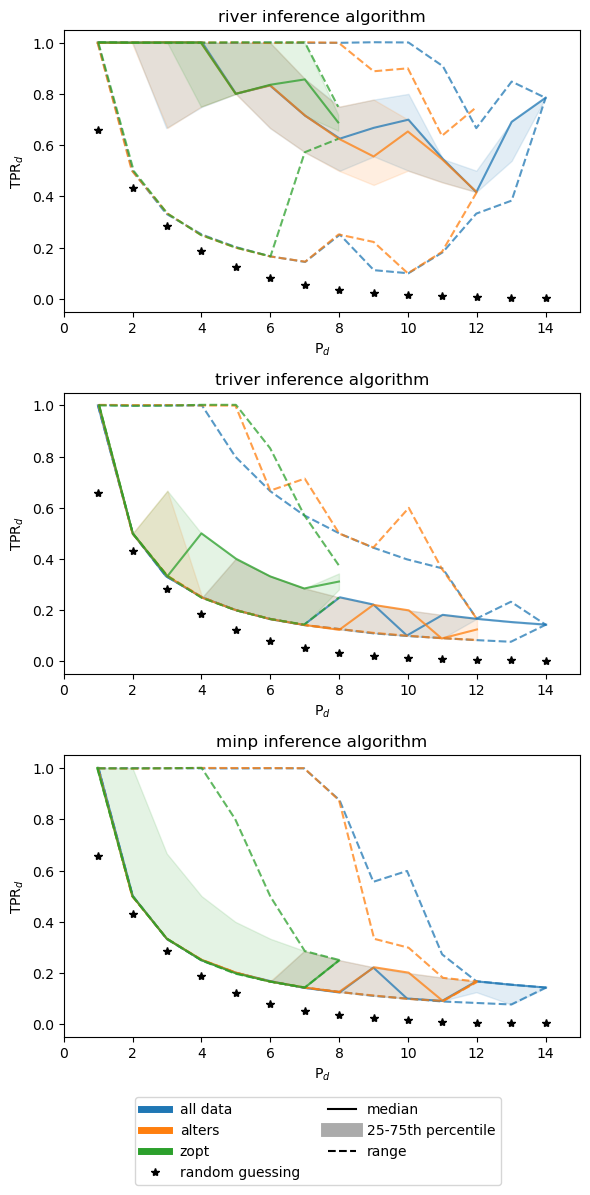

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(6, 12))
for alg_i, alg in enumerate(ALGORITHMS):
    filt_a = tprs_p_df[tprs_p_df["algorithm"] == alg]
    #plt.figure(figsize=(8,4))
    for i, sm in enumerate(SHARING_METHODS):
        filt = filt_a[filt_a["sharing_method"]==sm]
        ps, medians, minimums, maximums = [], [], [], []
        q25, q75 = [], []
        for p in range(15):
            filt_p = filt[filt["P"] == p]
            if len(filt_p) == 0: continue
            medians.append(filt_p["TPR"].median())
            minimums.append(filt_p["TPR"].min())
            maximums.append(filt_p["TPR"].max())
            q25.append(filt_p["TPR"].quantile(.25))
            q75.append(filt_p["TPR"].quantile(.75))
            ps.append(p)
            
        #for graphical indistinguishability:
        ps = np.array(ps)+np.random.normal(0, 0.015, len(ps))
        medians = np.array(medians)+np.random.normal(0, 0.001, len(medians))
        minimums = np.array(minimums)+np.random.normal(0, 0.001, len(minimums))
        maximums = np.array(maximums)+np.random.normal(0, 0.001, len(maximums))

        axes[alg_i].plot(ps, medians, color=COLOR[i], alpha=0.75, label=f"{sm} median" if alg_i==2 else "")
        axes[alg_i].fill_between(ps, q25, q75, color=COLOR[i], alpha=0.125, label=f"{sm} 25-75th percentile" if alg_i==2 else "")
        axes[alg_i].plot(ps, minimums, "--", color=COLOR[i], alpha=0.75, label=f"{sm} range" if alg_i==2 else "")
        axes[alg_i].plot(ps, maximums, "--", color=COLOR[i], alpha=0.75, label="")
        axes[alg_i].set_xlabel("P$_d$")
        axes[alg_i].set_ylabel("TPR$_d$")
        axes[alg_i].set_xlim(0, 15)
        axes[alg_i].set_ylim(-.05, 1.05)

        if i==0:
            axes[alg_i].plot(ideal_x, ideal_y, "*", color="k", label="random guessing" if alg_i==2 else "")
    #if alg_i == 2:
    #    axes[alg_i].legend(loc="lower center", ncols=3, bbox_to_anchor=(.5, -.5))
    axes[alg_i].set_title(f"{alg} inference algorithm")

plt.legend(handles=legend_elements, loc="lower left", ncols=2,
           bbox_to_anchor=(0.125, -.55, 0, 0))
plt.tight_layout()

#### Local sharing security properties

In [13]:
METRICS = ["TPR$_d$", "TPR$_r$",
           "FPR$_d$", "FPR$_r$",
           "$S_c(d, \widehat{R})$", "$S_c(R, \widehat{R})$",
           "distance"]

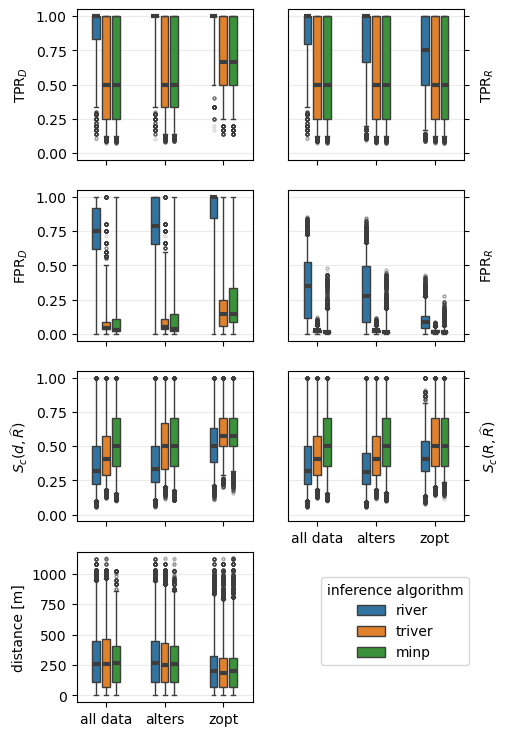

In [52]:
fig = plt.figure(figsize=(9, 9))
for i, vt in enumerate(METRICS):
    df = long_eval_df[long_eval_df["value_type"] == vt]
    ax = fig.add_subplot(4,2,i+1)
    ax.grid(visible=True, axis="y", alpha=0.25)
    sns.boxplot(ax = ax, data = df, x="sharing_method", y="value", hue="algorithm",
                width=0.5, gap=0.2, whis=[1, 99], legend=i==5, fliersize=2.0, flierprops={"alpha": 0.2},
                medianprops={"linewidth":3})
    if vt.startswith("TPR") or vt.startswith("FPR"):
        vt = vt.upper()
    elif vt=="distance":
        vt = "distance [m]"
    #ax.set_title(f"Local privacy: {vt}")
    ax.set_xlabel("")
    ax.set_ylabel(f"{vt}")
    if vt!="distance [m]":
        ax.set_ylim(-0.05, 1.05)
        
    if i==5:
        ax.legend(title="inference algorithm")
        sns.move_legend(ax, "lower left", bbox_to_anchor=(0.15, -1.), )
        
    if i%2 == 1:
        ax.yaxis.tick_right()
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_label_position("right")
        
    if i<5:
        ax.xaxis.set_ticklabels([])
        
    
#fig.suptitle("Local privacy metrics")
fig.set_figheight(9)
fig.set_figwidth(5)
#plt.tight_layout()
plt.show()

In [14]:
mean_dict, median_dict = {}, {}
means, medians = {}, {}
for ifa in ALGORITHMS:
    for metric in METRICS:
        median_dict[metric] = {}
        mean_dict[metric] = {}
        for sm in SHARING_METHODS_NAMES:
            filt = long_eval_df[long_eval_df["value_type"] == metric]
            filt = filt[filt["algorithm"] == ifa]
            filt = filt[filt["sharing_method"] == sm]
            median_dict[metric][sm] = filt["value"].median()
            mean_dict[metric][sm] = filt["value"].mean()
    medians[ifa] = pd.DataFrame.from_dict(median_dict, orient="index")
    means[ifa] = pd.DataFrame.from_dict(mean_dict, orient="index")

In [15]:
for x in means:
    means[x].to_csv(f"{LOC_PRIV_RESULTS}/{x}.csv")

### Broad vs Narrow Difference

In [23]:
import seaborn as sns

In [31]:
diffs = {}
for algo in ALGORITHMS:
    #read broad:
    broad = pd.read_csv(f"{LOC_PRIV_RESULTS}/{algo}_broad.csv")
    broad = broad.rename(columns = {"Unnamed: 0": "metrics"})
    broad["metrics"] = pd.Categorical(
        broad["metrics"],
        ordered = True,
        categories = ["TPR$_d$", "TPR$_r$", "distance",
                      "FPR$_d$", "FPR$_r$",
                      "$S_c(d, \widehat{R})$", "$S_c(R, \widehat{R})$"]
    )
    broad = broad.set_index("metrics")
    
    #read narrow:
    narrow = pd.read_csv(f"{LOC_PRIV_RESULTS}/{algo}_narrow.csv")
    narrow = narrow.rename(columns = {"Unnamed: 0": "metrics"})
    narrow["metrics"] = pd.Categorical(
        narrow["metrics"],
        ordered = True,
        categories = ["TPR$_d$", "TPR$_r$", "distance",
                      "FPR$_d$", "FPR$_r$",
                      "$S_c(d, \widehat{R})$", "$S_c(R, \widehat{R})$"]
    )
    narrow = narrow.set_index("metrics")
    
    diffs[algo] = (narrow-broad)/broad*100

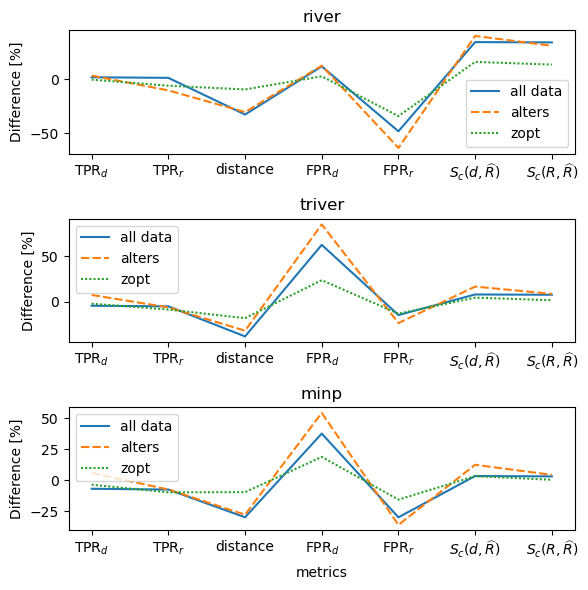

In [47]:
fig, ax = plt.subplots(3,1, figsize=(6,6))
for i, algo in enumerate(ALGORITHMS):
    sns.lineplot(data = diffs[algo], ax = ax[i])
    ax[i].set_ylabel("Difference [%]")
    ax[i].set_title(algo)
    if i<2:
        ax[i].set_xlabel("")
        
fig.tight_layout()